In [59]:
# Load necessary libraries
if (!requireNamespace("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager")
}
BiocManager::install(c("minfi", "limma"))
install.packages("caret")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.0 (2023-04-21)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'minfi' 'limma'”
Installation paths not writeable, unable to update packages
  path: /u/local/apps/R/4.3.0/gcc10.2.0_intel2022.1.1/lib64/R/library
  packages:
    BiocGenerics, BiocParallel, Biostrings, bitops, boot, bslib, cachem, class,
    cli, cluster, codetools, colorspace, cpp11, crayon, curl, data.table,
    deldir, digest, dqrng, evaluate, fansi, farver, fastDummies, fastmap,
    fitdistrplus, foreign, fs, future, future.apply, GenomeInfoDb,
    GenomeInfoDbData, GenomicRanges, ggplot2, globals, glue, gtable, highr,
    htmltools, httpuv, igraph, IRanges, jsonlite, KernSmooth, lattice,
    l

In [1]:
library(minfi)
library(limma)
library(caret) # For data splitting
library(survival)
library(dplyr)
library(data.table)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loa

In [5]:
transformed_methylation_data <- read.csv("/u/home/c/ctang04/Liver Project/data/transformed_log1k_methylation_data.csv", row.names = 1, check.names=FALSE)
# Load phenotype data
phenotype_matrix <- read.csv("/u/home/c/ctang04/Liver Project/data/patients.info.for.liver.study_with.seq.data_2024.07.21.csv", check.names = FALSE)

In [6]:
saveRDS(transformed_methylation_data, file = "/u/home/c/ctang04/Liver Project/data/transformed_methyl_data_frame.rds")
saveRDS(phenotype_matrix, file = "/u/home/c/ctang04/Liver Project/data/phenotype_matrix.rds")

In [2]:
# Read the transformed methylation data
transformed_methylation_data <- readRDS("/u/home/c/ctang04/Liver Project/data/transformed_methyl_data_frame.rds")

# Read the phenotype matrix
phenotype_matrix <- readRDS("/u/home/c/ctang04/Liver Project/data/phenotype_matrix.rds")

dim(transformed_methylation_data)
dim(phenotype_matrix)

[1] 144965   5610

[1] 647  69

In [3]:
# Extract unique sample aliases from phenotype data
phenotype_sample_names <- phenotype_matrix$plasma_alias
split_pheno_names <- unlist(strsplit(as.character(phenotype_sample_names), "; "))
unique_sample_aliases <- unique(split_pheno_names)

# Match sample names between methylation and phenotype data
sample_names <- colnames(transformed_methylation_data)
matches <- sapply(sample_names, function(sample) any(grepl(sample, unique_sample_aliases)))
matched_sample_names <- sample_names[matches]

# Filter methylation data to include only matched samples
filtered_methyl_data <- transformed_methylation_data[, matched_sample_names, drop = FALSE]

# Split phenotype data to match the filtered methylation data
split_phenotype_data <- phenotype_matrix[rep(seq_len(nrow(phenotype_matrix)), sapply(phenotype_matrix$plasma_alias, function(x) length(strsplit(x, "; ")[[1]]))), ]
split_phenotype_data$plasma_alias <- unlist(strsplit(as.character(phenotype_matrix$plasma_alias), "; "))
split_phenotype_data <- split_phenotype_data[!is.na(split_phenotype_data$plasma_alias), ]

# Match common samples between methylation and phenotype data
common_samples <- intersect(colnames(filtered_methyl_data), split_phenotype_data$plasma_alias)
filtered_pheno_data <- split_phenotype_data[split_phenotype_data$plasma_alias %in% common_samples, ]
filtered_pheno_data <- filtered_pheno_data[match(colnames(filtered_methyl_data), filtered_pheno_data$plasma_alias), ]

# Combine methylation and phenotype data
transposed_methyl_data <- as.data.frame(t(filtered_methyl_data))
print(dim(transposed_methyl_data))
combined_data <- cbind(transposed_methyl_data, filtered_pheno_data)
print(dim(combined_data))

# Ensure no NA values in 'ast_U_L'
combined_data_clean <- combined_data[!is.na(combined_data$ast_U_L), ]
print(dim(combined_data_clean))

[1]    578 144965
[1]    578 145034
[1]    563 145034


In [4]:
combined_data_clean_aliases <- combined_data_clean[,"plasma_alias"]
rownames(combined_data_clean) <- combined_data_clean_aliases

In [8]:
#write.csv(combined_data_clean, "/u/home/c/ctang04/Liver Project/data/ast_samples_withdup.csv")

In [5]:
# Remove duplicates in place by selecting the first sample for each donor
rownames_combined <- rownames(combined_data_clean)

combined_data_clean <- combined_data_clean %>%
  mutate(rowname = rownames_combined) %>%
  group_by(donor_id) %>%
  slice(1) %>%
  ungroup()

print(combined_data_clean$plasma_alias)

  [1] "plasma-2333-P9-LV"            "plasma-2300-P9-LV"           
  [3] "plasma-2270-P9-LV"            "plasma-1969-P9-LV"           
  [5] "plasma-1976-P9-N"             "plasma-2742-P9-N"            
  [7] "plasma-2800-P9-N"             "plasma-3931-P9-N"            
  [9] "plasma-2518-P9-N"             "plasma-2357-P9-N"            
 [11] "plasma-2873-P9-N"             "plasma-1959-P9-N"            
 [13] "plasma-3038-P9-LV"            "plasma-2091-P9-N"            
 [15] "plasma-3390-P9-LV"            "plasma-2741-P9-N"            
 [17] "plasma-2104-P9-N"             "plasma-2188-P9-BD"           
 [19] "plasma-3627-P9-LV"            "plasma-3134-P9-N"            
 [21] "plasma-2733-P9-N"             "plasma-2743-P9-N"            
 [23] "plasma-2778-P9-PR"            "plasma-2370-P9-N"            
 [25] "plasma-2248-P9-N"             "plasma-3427-P9-N"            
 [27] "plasma-2549-P9-N"             "plasma-2090-P9-N"            
 [29] "plasma-2441-P9-N"             "plasma-199

In [6]:
combined_data_clean_aliases_nodup <- combined_data_clean$plasma_alias
print(combined_data_clean_aliases_nodup)

  [1] "plasma-2333-P9-LV"            "plasma-2300-P9-LV"           
  [3] "plasma-2270-P9-LV"            "plasma-1969-P9-LV"           
  [5] "plasma-1976-P9-N"             "plasma-2742-P9-N"            
  [7] "plasma-2800-P9-N"             "plasma-3931-P9-N"            
  [9] "plasma-2518-P9-N"             "plasma-2357-P9-N"            
 [11] "plasma-2873-P9-N"             "plasma-1959-P9-N"            
 [13] "plasma-3038-P9-LV"            "plasma-2091-P9-N"            
 [15] "plasma-3390-P9-LV"            "plasma-2741-P9-N"            
 [17] "plasma-2104-P9-N"             "plasma-2188-P9-BD"           
 [19] "plasma-3627-P9-LV"            "plasma-3134-P9-N"            
 [21] "plasma-2733-P9-N"             "plasma-2743-P9-N"            
 [23] "plasma-2778-P9-PR"            "plasma-2370-P9-N"            
 [25] "plasma-2248-P9-N"             "plasma-3427-P9-N"            
 [27] "plasma-2549-P9-N"             "plasma-2090-P9-N"            
 [29] "plasma-2441-P9-N"             "plasma-199

In [11]:
#write.csv(combined_data_clean, "/u/home/c/ctang04/Liver Project/data/ast_samples_nodup.csv")

In [7]:
as.data.frame(combined_data_clean)
rownames(combined_data_clean) <- combined_data_clean$plasma_alias

chr10_100027865_100027984,chr10_100028045_100028164,chr10_100028161_100028280,chr10_100028371_100028490,chr10_100069285_100069404,chr10_100108994_100109113,chr10_100174700_100174819,chr10_100174780_100174899,chr10_100206002_100206121,chr10_100206118_100206237,⋯,hbv_load_IU_L,hbv_antigen,hbv_hepatitis_delta_antibody,hbv_treatment,meld_score,meld_na_score,child_pugh_score,child_pugh_class,site_id_cc,rowname
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>
0.000000,0,0,0,1.379512,4.468386,2.764103,2.556595,0.000000,0.000000,⋯,NA,NA,NA,NA,11,NA,3,3,UCLA,plasma-2333-P9-LV
0.000000,0,0,0,1.613601,3.718647,2.201849,2.201849,0.000000,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2300-P9-LV
1.515843,0,0,0,1.515843,4.497935,3.994503,3.495880,2.092668,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2270-P9-LV
0.000000,0,0,0,0.000000,4.102887,2.655036,2.390516,3.036790,0.000000,⋯,NA,NA,NA,NA,19,NA,6,A,UCLA,plasma-1969-P9-LV
0.000000,0,0,0,0.000000,3.661828,3.661828,3.484630,1.990893,1.990893,⋯,NA,NA,NA,NA,40,NA,3,3,UCLA,plasma-1976-P9-N
0.000000,0,0,0,1.253560,4.152138,4.565452,4.331834,2.141051,0.000000,⋯,NA,NA,NA,NA,NA,9,3,3,UCLA,plasma-2742-P9-N
0.000000,0,0,0,0.000000,4.431948,2.989978,3.163883,0.000000,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2800-P9-N
0.000000,0,0,0,0.000000,4.532344,5.506428,5.373476,3.455014,3.065219,⋯,NA,NA,NA,NA,NA,NA,6,A,UCLA,plasma-3931-P9-N
0.000000,0,0,0,0.000000,3.025081,3.844242,3.975094,0.000000,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2518-P9-N


Warning message:
“Setting row names on a tibble is deprecated.”


In [8]:
# Check if 'plasma_alias' is a column in the dataframe
"plasma_alias" %in% colnames(combined_data_clean)
"ast_U_L" %in% colnames(combined_data_clean)

[1] TRUE

[1] TRUE

In [9]:
max_ast_U_L <- max(combined_data_clean$ast_U_L, na.rm = TRUE)
min_ast_U_L <- min(combined_data_clean$ast_U_L, na.rm = TRUE)

# Print largest and smallest value
cat("The largest value in ast_U_L is:", max_ast_U_L, "\n")
cat("The smallest value in ast_U_L is:", min_ast_U_L, "\n")

The largest value in ast_U_L is: 4091 
The smallest value in ast_U_L is: 0.59 


# Log Transformation

In [10]:
# Ensure all values in ast_U_L are positive by adding a small constant (if necessary)
min_ast <- min(combined_data_clean$ast_U_L, na.rm = TRUE)
if (min_ast <= 0) {
  combined_data_clean$ast_U_L <- combined_data_clean$ast_U_L + (1 - min_ast)
}

# Apply log transformation to ast_U_L
combined_data_clean$log_ast_U_L <- log(combined_data_clean$ast_U_L)

# View the first few rows to verify the transformation
combined_data_clean <- as.data.frame(combined_data_clean)
rownames(combined_data_clean) <- combined_data_clean$plasma_alias
head(combined_data_clean)
# Convert to data.table and ensure all columns are numeric where appropriate
combined_data_clean_dt <- as.data.table(combined_data_clean)

,chr10_100027865_100027984,chr10_100028045_100028164,chr10_100028161_100028280,chr10_100028371_100028490,chr10_100069285_100069404,chr10_100108994_100109113,chr10_100174700_100174819,chr10_100174780_100174899,chr10_100206002_100206121,chr10_100206118_100206237,⋯,hbv_antigen,hbv_hepatitis_delta_antibody,hbv_treatment,meld_score,meld_na_score,child_pugh_score,child_pugh_class,site_id_cc,rowname,log_ast_U_L
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>
plasma-2333-P9-LV,0.000000,0,0,0,1.379512,4.468386,2.764103,2.556595,0.000000,0.000000,⋯,NA,NA,NA,11,NA,3,3,UCLA,plasma-2333-P9-LV,4.356709
plasma-2300-P9-LV,0.000000,0,0,0,1.613601,3.718647,2.201849,2.201849,0.000000,0.000000,⋯,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2300-P9-LV,3.044522
plasma-2270-P9-LV,1.515843,0,0,0,1.515843,4.497935,3.994503,3.495880,2.092668,0.000000,⋯,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2270-P9-LV,3.295837
plasma-1969-P9-LV,0.000000,0,0,0,0.000000,4.102887,2.655036,2.390516,3.036790,0.000000,⋯,NA,NA,NA,19,NA,6,A,UCLA,plasma-1969-P9-LV,3.912023
plasma-1976-P9-N,0.000000,0,0,0,0.000000,3.661828,3.661828,3.484630,1.990893,1.990893,⋯,NA,NA,NA,40,NA,3,3,UCLA,plasma-1976-P9-N,4.276666
plasma-2742-P9-N,0.000000,0,0,0,1.253560,4.152138,4.565452,4.331834,2.141051,0.000000,⋯,NA,NA,NA,NA,9,3,3,UCLA,plasma-2742-P9-N,4.644391


# Removing Columns

In [11]:
columns_to_remove <- colnames(filtered_pheno_data)

# Remove columns in `combined_data_clean` that are present in `columns_to_remove`
combined_data_clean_filtered <- combined_data_clean[, !colnames(combined_data_clean) %in% columns_to_remove]

# Verify the dimensions of the cleaned dataset
print(dim(combined_data_clean_filtered))

[1]    465 144967


In [12]:
non_numeric_cols <- sapply(combined_data_clean, function(x) !is.numeric(x) && !is.integer(x))
print(names(combined_data_clean_dt)[non_numeric_cols])

 [1] "donor_id"                     "plasma_alias"                
 [3] "tumor_tissue_alias"           "normal_tissue_alias"         
 [5] "sample_source"                "info_source"                 
 [7] "phase_HBV"                    "gender"                      
 [9] "race"                         "hispanic"                    
[11] "specimen_collection_date"     "dx_cirrhosis"                
[13] "dx_hcc"                       "bclc_stage"                  
[15] "prime_etiology"               "non_prime_liver_disease_name"
[17] "prime_liver_disease_name"     "ascites"                     
[19] "ascietes_severity"            "encephalopathy"              
[21] "encephalopathy_severity"      "afp_ng_mL"                   
[23] "hbv_antigen"                  "hbv_hepatitis_delta_antibody"
[25] "hbv_treatment"                "child_pugh_class"            
[27] "site_id_cc"                   "rowname"                     


In [13]:
dim(combined_data)
dim(combined_data_clean)

[1]    578 145034

[1]    465 145036

# Read in Folds

In [18]:
# # Set seed for reproducibility
# set.seed(123)

# # Number of folds
# k <- 5

# # Create k-fold cross-validation indices
# folds <- createFolds(combined_data_clean$log_ast_U_L, k = k, list = TRUE, returnTrain = TRUE)

# # Perform k-fold cross-validation manually and save each fold's data
# for (i in 1:k) {
#   # Get the training and testing indices
#     train_indices <- folds[[i]]
#     test_indices <- setdiff(1:nrow(combined_data_clean), train_indices)
  
#     # Subset the training and testing data
#     training_set <- combined_data_clean[train_indices, ]
#     testing_set <- combined_data_clean[test_indices, ]

#   # Save the data as .rds
#     saveRDS(training_set, file = paste0("/u/home/c/ctang04/Liver Project/data/ast_training_set_fold_", i, ".rds"))
#     saveRDS(testing_set, file = paste0("/u/home/c/ctang04/Liver Project/data/ast_testing_set_fold_", i, ".rds"))
# }

In [14]:
# Read .rds files
k<-5
training_sets <- lapply(1:k, function(i) readRDS(paste0("/u/home/c/ctang04/Liver Project/data/ast_training_set_fold_", i, ".rds")))
testing_sets <- lapply(1:k, function(i) readRDS(paste0("/u/home/c/ctang04/Liver Project/data/ast_testing_set_fold_", i, ".rds")))

In [15]:
# Check if 'log_ast_U_L' exists in training and testing sets
for (i in 1:k) {
  cat(paste("Fold", i, "\n"))
  
  # Check in training set
  if ("log_ast_U_L" %in% colnames(training_sets[[i]])) {
    cat("  log_ast_U_L found in training set\n")
  } else {
    cat("  log_ast_U_L NOT found in training set\n")
  }
  
  # Check in testing set
  if ("log_ast_U_L" %in% colnames(testing_sets[[i]])) {
    cat("  log_ast_U_L found in testing set\n")
  } else {
    cat("  log_ast_U_L NOT found in testing set\n")
  }
}

Fold 1 
  log_ast_U_L found in training set
  log_ast_U_L found in testing set
Fold 2 
  log_ast_U_L found in training set
  log_ast_U_L found in testing set
Fold 3 
  log_ast_U_L found in training set
  log_ast_U_L found in testing set
Fold 4 
  log_ast_U_L found in training set
  log_ast_U_L found in testing set
Fold 5 
  log_ast_U_L found in training set
  log_ast_U_L found in testing set


# Predicting Values

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:IRanges’:

    cov, var


The following objects are masked from ‘package:S4Vectors’:

    cov, var


The following object is masked from ‘package:BiocGenerics’:

    var


The following objects are masked from ‘package:stats’:

    cov, smooth, var




[1] 372   2
[1]    372 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message in predict.lm(model, newdata = testing_set_filtered):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


[1] 372   2
[1]    372 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


[1] 371   2
[1]    371 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


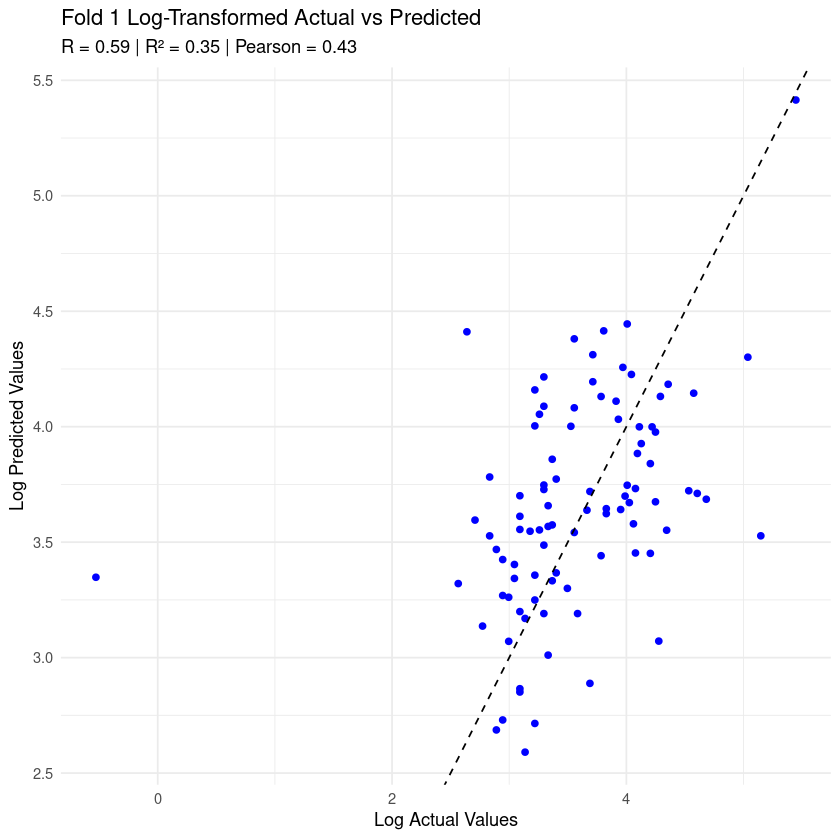

[1] 372   2
[1]    372 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


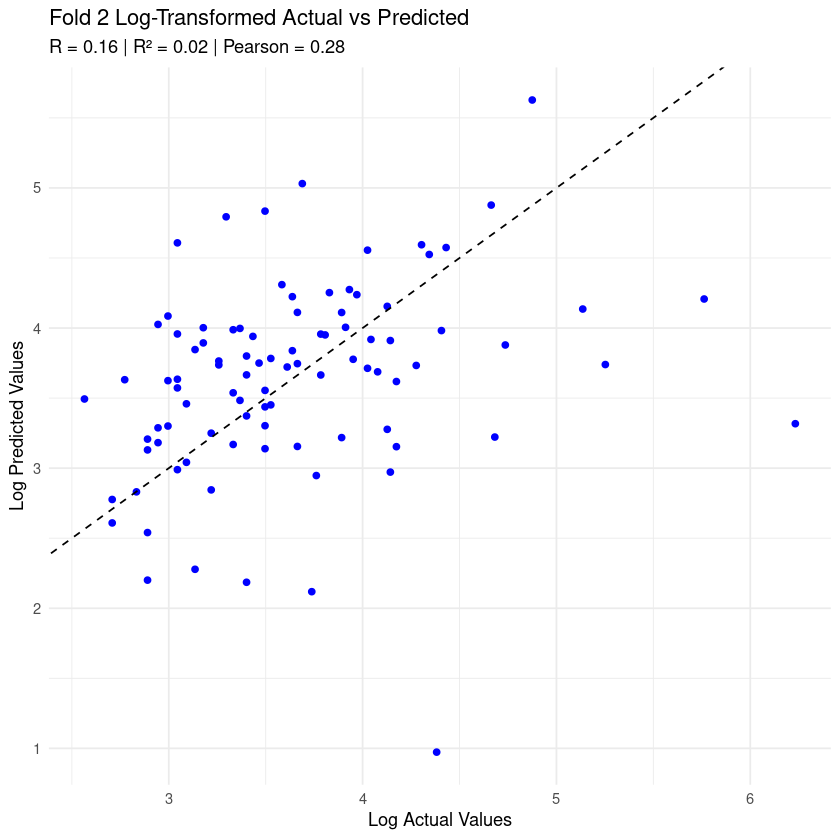

[1] 373   2
[1]    373 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


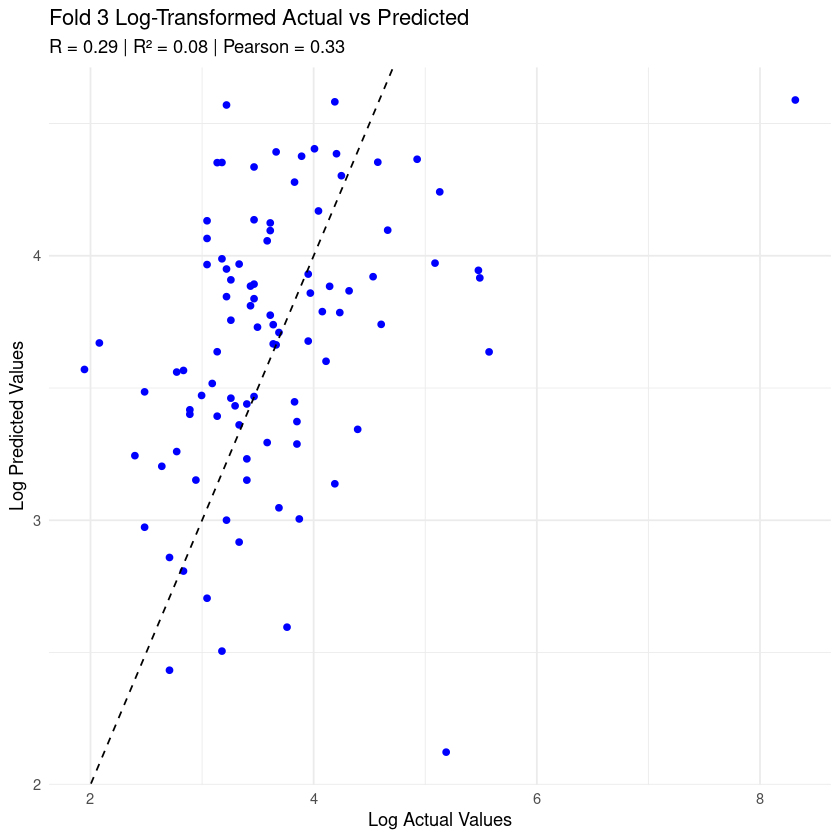

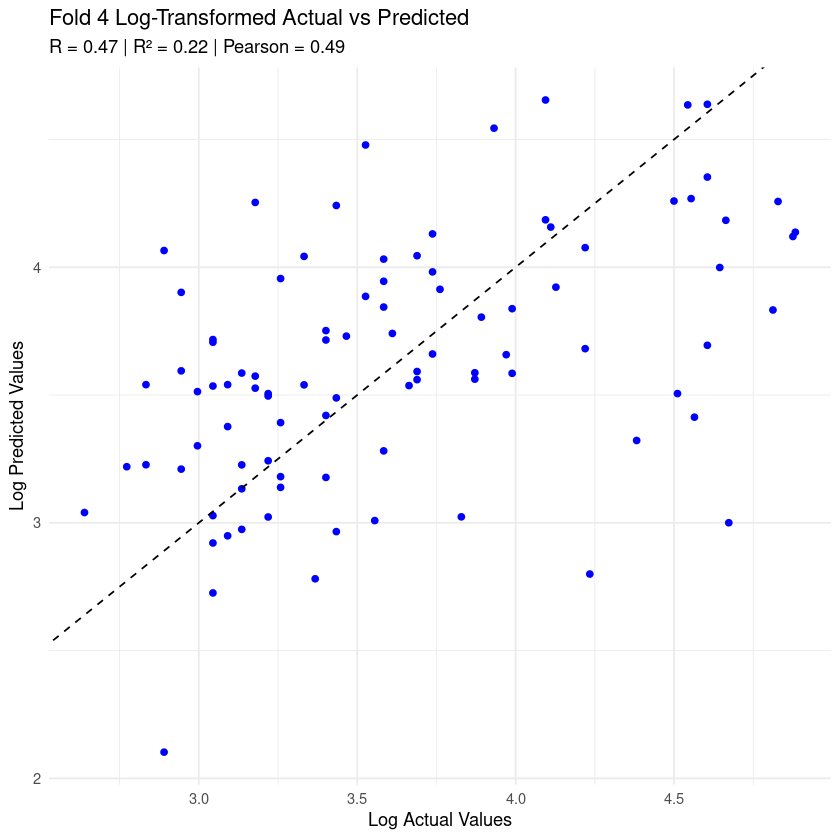

                RMSE   Rsquared      MAE
performance 47.13571 0.17476814 39.81726
performance 57.40749 0.09964714 44.24672
performance 45.60193 0.15637583 40.74646
performance 43.66588 0.25561341 38.63845
performance 51.28241 0.16288832 41.88506
      RMSE   Rsquared        MAE 
49.0186846  0.1698586 41.0667912 
Shared markers across all folds:
[1] 32
Shared markers across all folds: 
[1] 12055


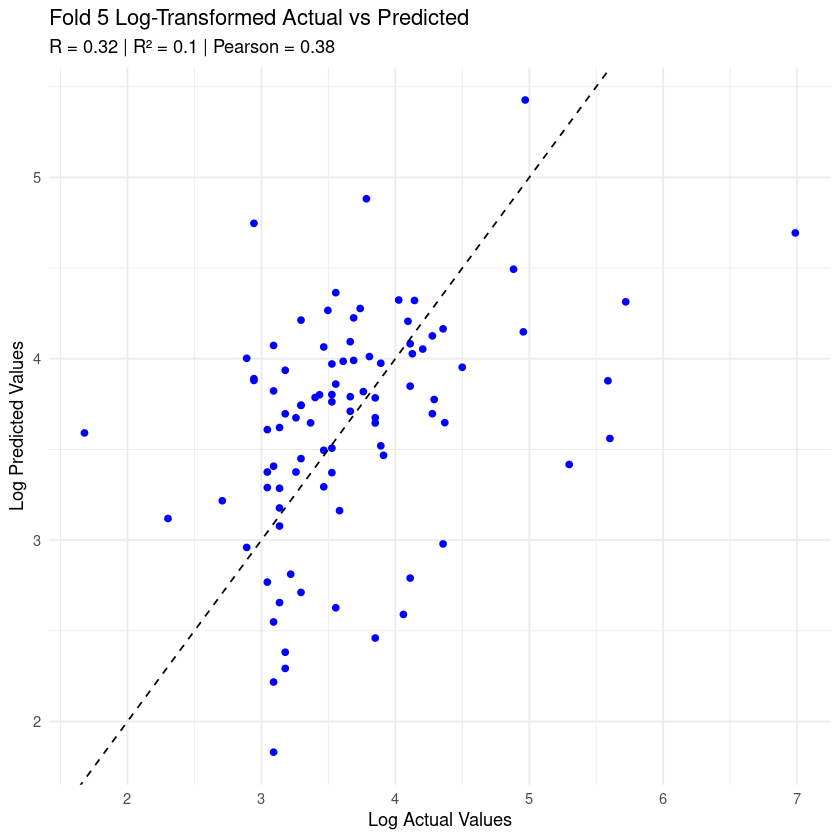

In [16]:
library(caret)
library(limma)
library(ggplot2)
library(pROC)

# Set seed for reproducibility
set.seed(123)

# Number of folds
k <- 5

# Initialize lists to store results
all_predictions <- list()
all_performances <- vector()
all_top_markers <- list()
all_top_markers_FC <- list()

# Perform k-fold cross-validation manually
for (i in 1:k) {
   # Use the preloaded training and testing sets
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ log_ast_U_L, data = training_set)

    # Remove 'log_ast_U_L' column from methylation data
    methylation_data_no_log_ast <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "log_ast_U_L"]

    # Check dimensions
    print(dim(design_train))  # Dimensions of design matrix
    print(dim(methylation_data_no_log_ast))  # Dimensions of filtered data

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_log_ast), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    #print(head(top_100_results))
    top_100_markers <- rownames(top_100_results)
    # Get top markers with logFC > 1.2 (log scale) and lowest p-value
    top_results <- topTable(fit, coef = 2, number = Inf)

    # Exponentiate the logFC column (assuming base 2)
    top_results$FoldChange <- 2^top_results$logFC

    #print(head(top_results))

    top_results_filtered <- top_results[abs(top_results$FoldChange) > 1.2, ]
    #print(dim(top_results_filtered))
    #top_results_sorted <- top_results_filtered[order(top_results_filtered$P.Value), ]
    #print(dim(top_results_sorted))
    top_100_markers_FC <- (rownames(top_results_filtered))
    # Store the top 100 markers for the current fold
    all_top_markers[[i]] <- top_100_markers
    all_top_markers_FC[[i]] <- top_100_markers_FC
    # Export top 100 markers for the current fold to a CSV file
    write.csv(top_100_markers, file = paste0("AST_Linear_top_100_markers_fold_", i, ".csv"), row.names = FALSE)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("log_ast_U_L", top_100_markers)]
    testing_set_filtered <- testing_set[, c("log_ast_U_L", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(log_ast_U_L ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    log_predictions <- predict(model, newdata = testing_set_filtered)
    predictions <- exp(log_predictions)

    # Store the predictions
    all_predictions[[i]] <- data.frame(
        PlasmaAlias = testing_set$plasma_alias,
        Actual = testing_set$ast_U_L,
        Predicted = predictions
    )

    # Calculate and store the performance metrics for the current fold
    performance <- postResample(predictions, testing_set$log_ast_U_L)
    all_performances <- rbind(all_performances, performance)

    # Plot the actual vs predicted values
    plot_data <- data.frame(
        Actual = testing_set$ast_U_L,
        Predicted = predictions
    )

    # Calculate Pearson Correlation Coefficient R and R2
    r_value <- cor(plot_data$Actual, plot_data$Predicted)
    r_squared <- r_value^2
    pearson_corr <- cor(log(plot_data$Actual), log(plot_data$Predicted), method = "pearson")
    # Create the plot for log-transformed values with y = x line and Pearson correlation
    p <- ggplot(plot_data, aes(x = log(Actual), y = log(Predicted))) +
        geom_point(color = "blue") +
        #geom_smooth(method = "lm", color = "red", se = FALSE) + # Add a linear regression line
        geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") + # Add the y = x line
        labs(title = paste("Fold", i, "Log-Transformed Actual vs Predicted"),
             subtitle = paste("R =", round(r_value, 2), "| R² =", round(r_squared, 2), "| Pearson =", round(pearson_corr, 2)),
             x = "Log Actual Values",
             y = "Log Predicted Values") +
        #coord_cartesian(xlim = c(0, log(150)), ylim = c(0, log(150))) + # Set limits for x and y axes on log scale
        theme_minimal()
    print(p)
}
# Calculate average performance across all folds
print(all_performances)
mean_performance <- colMeans(all_performances)
print(mean_performance)

# Print the top 100 markers for each fold
# for (i in 1:k) {
#   cat(paste("Top 100 markers for fold", i, ":\n"))
#   print(all_top_markers[[i]])
# }

# Find shared top markers across all folds after the loop
shared_markers <- Reduce(intersect, all_top_markers)

# Print the shared markers to a CSV file
write.csv(shared_markers, file = "AST_shared_top_100_markers.csv", row.names = FALSE)

# Print the shared markers
cat("Shared markers across all folds:\n")
print(length(shared_markers))

shared_markers_FC <- Reduce(intersect, all_top_markers_FC)
cat("Shared markers across all folds: \n")
print(length(shared_markers_FC))

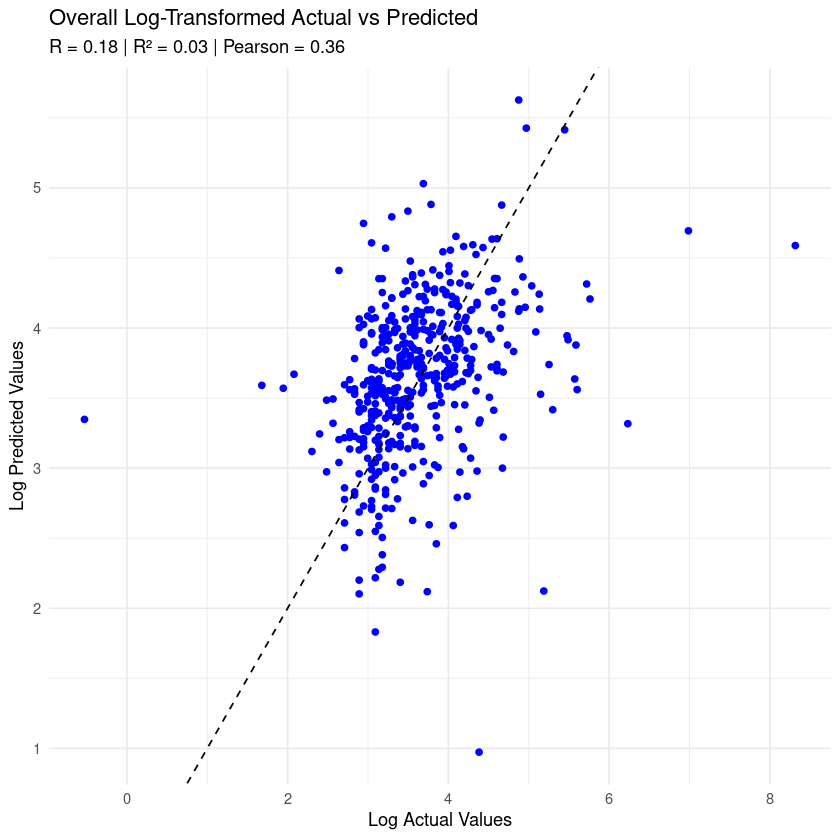

In [17]:
library(ggplot2)

# Combine all predictions from the k folds
combined_predictions <- do.call(rbind, all_predictions)

# Calculate Pearson Correlation Coefficient R and R² for combined data
r_value_combined <- cor(combined_predictions$Actual, combined_predictions$Predicted)
r_squared_combined <- r_value_combined^2
pearson_corr_combined <- cor(log(combined_predictions$Actual), log(combined_predictions$Predicted), method = "pearson")

# Create the scatter plot for log-transformed values with y = x line
overall_plot <- ggplot(combined_predictions, aes(x = log(Actual), y = log(Predicted))) +
  geom_point(color = "blue") +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") + # Add y = x line
  labs(title = "Overall Log-Transformed Actual vs Predicted",
       subtitle = paste("R =", round(r_value_combined, 2), "| R² =", round(r_squared_combined, 2), "| Pearson =", round(pearson_corr_combined, 2)),
       x = "Log Actual Values",
       y = "Log Predicted Values") +
  theme_minimal()

# Print the overall scatter plot
print(overall_plot)

In [18]:
# Calculate average performance across all folds
print(all_performances)
mean_performance <- colMeans(all_performances)
print(mean_performance)

# Print the top 100 markers for each fold
# for (i in 1:k) {
#   cat(paste("Top 100 markers for fold", i, ":\n"))
#   print(all_top_markers[[i]])
# }

# Find shared top markers across all folds after the loop
shared_markers <- Reduce(intersect, all_top_markers)

# Print the shared markers to a CSV file
write.csv(shared_markers, file = "AST_shared_top_100_markers.csv", row.names = FALSE)

# Print the shared markers
cat("Shared markers across all folds:\n")
print(length(shared_markers))

                RMSE   Rsquared      MAE
performance 47.13571 0.17476814 39.81726
performance 57.40749 0.09964714 44.24672
performance 45.60193 0.15637583 40.74646
performance 43.66588 0.25561341 38.63845
performance 51.28241 0.16288832 41.88506
      RMSE   Rsquared        MAE 
49.0186846  0.1698586 41.0667912 
Shared markers across all folds:
[1] 32


# Linear Classification

In [26]:
library(caret)
library(limma)
library(pROC)
library(ggplot2)
library(reshape2)

# Set seed for reproducibility
set.seed(123)

# Number of folds
k <- 5

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$log_ast_U_L, k = k, list = TRUE, returnTrain = TRUE)

# Initialize lists to store results
all_conf_matrices <- list()
all_top_markers <- list()
all_auc <- list()
all_correlations <- numeric(k)

# Define classification thresholds
classify <- function(value) {
  if (value <= 33) {
    return(0)
  } else {
    return(1)
  }
}

# Function to plot confusion matrix
plot_confusion_matrix <- function(conf_matrix, fold_number) {
  df <- as.data.frame(as.table(conf_matrix$table))
  names(df) <- c("Prediction", "Actual", "Frequency")
  
  ggplot(df, aes(x = Prediction, y = Actual, fill = Frequency)) +
    geom_tile() +
    geom_text(aes(label = sprintf("%d", Frequency)), vjust = 1) +
    scale_fill_gradient(low = "white", high = "blue") +
    theme_minimal() +
    labs(title = paste("Confusion Matrix - Fold", fold_number), x = "Predicted", y = "Actual") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
}

# Perform k-fold cross-validation manually
for (i in 1:k) {
    # Use the preloaded training and testing sets
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Classify the training data based on the cutoff
    training_set$class <- sapply(training_set$ast_U_L, classify)

    # Create the design matrix using the classified training data
    design_train <- model.matrix(~ class, data = training_set)

    # Remove 'log_ast_U_L' column from methylation data
    methylation_data_no_log_ast <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "log_ast_U_L"]

    # Check dimensions
    print(dim(design_train))
    print(dim(methylation_data_no_log_ast))

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_log_ast), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)

    # Store the top 100 markers for the current fold
    all_top_markers[[i]] <- top_100_markers
    # Export top 100 markers for the current fold to a CSV file
    write.csv(top_100_markers, file = paste0("AST_Linear_top_100_markers_fold_", i, ".csv"), row.names = FALSE)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("log_ast_U_L", top_100_markers)]
    testing_set_filtered <- testing_set[, c(top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(log_ast_U_L ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    log_predictions <- predict(model, newdata = testing_set_filtered)
    predictions <- exp(log_predictions)  # Exponentiate the predictions

    # Exponentiate the actual values for comparison
    actual_values <- testing_set$ast_U_L

    # Print actual and predicted values before classification
    print(data.frame(
      PlasmaAlias = testing_set$plasma_alias,
      Actual = actual_values,
      Predicted = predictions
    ))

    # Classify predictions and actual values
    classified_predictions <- sapply(predictions, classify)
    classified_actuals <- sapply(actual_values, classify)

    # Convert predictions and actual values to factors
    classified_predictions <- factor(classified_predictions, levels = 0:1)
    classified_actuals <- factor(classified_actuals, levels = 0:1)

    # Create a confusion matrix
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Plot and save confusion matrix
    cm_plot <- plot_confusion_matrix(conf_matrix, i)
    ggsave(filename = paste0("Confusion_Matrix_Fold_", i, ".png"), plot = cm_plot)

    # Calculate Pearson's correlation coefficient
    correlation <- cor(actual_values, predictions)
    all_correlations[i] <- correlation

    # Calculate AUC using actual class labels and prediction probabilities
    roc_curve <- roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_curve)
    all_auc[i] <- auc_value

    # Print confusion matrix, Pearson's correlation, and AUC for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Pearson's Correlation Coefficient:", correlation, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
}

# Print confusion matrices, correlation coefficients, and AUC for each fold
for (i in 1:k) {
    cat(paste("Confusion Matrix for fold", i, ":\n"))
    print(all_conf_matrices[[i]])
    cat(paste("Fold", i, "Pearson's Correlation Coefficient:", all_correlations[i], "\n"))
    cat(paste("Fold", i, "AUC:", all_auc[i], "\n"))
}

# Calculate and print the mean AUC across all folds
mean_auc <- mean(unlist(all_auc))
cat(paste("Mean AUC across all folds:", mean_auc, "\n"))



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt




[1] 372   2
[1]    372 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual Predicted
plasma-2300-P9-LV                       plasma-2300-P9-LV  21.00  57.47857
plasma-2741-P9-N                         plasma-2741-P9-N  62.00  47.68685
plasma-3627-P9-LV                       plasma-3627-P9-LV  41.00  73.10491
plasma-2743-P9-N                         plasma-2743-P9-N  28.00  21.57112
plasma-2090-P9-N                         plasma-2090-P9-N  46.00  53.17230
plasma-2222-P9-N                         plasma-2222-P9-N  27.00  49.38684
plasma-2770-P9-N                         plasma-2770-P9-N  20.00  31.77666
plasma-2794-P9-N                         plasma-2794-P9-N  67.00  32.58968
plasma-3901-P9-N                         plasma-3901-P9-N  27.00  60.03765
plasma-3013-P9-N                         plasma-3013-P9-N  13.00  15.51965
plasma-3835-P9-N                         plasma-3835-P9-N  72.00 111.08137
plasma-3637-P9-LV                       plasma-3637-P9-LV  50.00  50.60106
plasma-632-P9-CH         

Saving 6.67 x 6.67 in image
Setting levels: control = 0, case = 1

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 23  8
         1 24 38
                                          
               Accuracy : 0.6559          
                 95% CI : (0.5502, 0.7514)
    No Information Rate : 0.5054          
    P-Value [Acc > NIR] : 0.002399        
                                          
                  Kappa : 0.3143          
                                          
 Mcnemar's Test P-Value : 0.008010        
                                          
            Sensitivity : 0.4894          
            Specificity : 0.8261          
         Pos Pred Value : 0.7419          
         Neg Pred Value : 0.6129          
             Prevalence : 0.5054          
         Detection Rate : 0.2473          
   Detection Prevalence : 0.3333          
      Balanced Accuracy : 0.6577          
                                          
       'Positive' Class : 0               
           

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual  Predicted
plasma-2270-P9-LV                       plasma-2270-P9-LV     27  96.857821
plasma-1969-P9-LV                       plasma-1969-P9-LV     50  51.682814
plasma-2518-P9-N                         plasma-2518-P9-N     30  28.402227
plasma-2357-P9-N                         plasma-2357-P9-N     56  76.626995
plasma-2873-P9-N                         plasma-2873-P9-N     52  24.363487
plasma-2370-P9-N                         plasma-2370-P9-N     21  46.490616
plasma-2549-P9-N                         plasma-2549-P9-N     49  26.261953
plasma-2441-P9-N                         plasma-2441-P9-N    108  23.158418
plasma-3629-P9-LV                       plasma-3629-P9-LV    509  31.578202
plasma-3599-P9-LV                       plasma-3599-P9-LV     29  94.627380
plasma-3450-P9-BC                       plasma-3450-P9-BC     28  32.815727
plasma-3377-P9-N                         plasma-3377-P9-N     34  34.627654
plasma-650-r

Saving 6.67 x 6.67 in image
Setting levels: control = 0, case = 1

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 23 16
         1 24 30
                                          
               Accuracy : 0.5699          
                 95% CI : (0.4631, 0.6722)
    No Information Rate : 0.5054          
    P-Value [Acc > NIR] : 0.1269          
                                          
                  Kappa : 0.1413          
                                          
 Mcnemar's Test P-Value : 0.2684          
                                          
            Sensitivity : 0.4894          
            Specificity : 0.6522          
         Pos Pred Value : 0.5897          
         Neg Pred Value : 0.5556          
             Prevalence : 0.5054          
         Detection Rate : 0.2473          
   Detection Prevalence : 0.4194          
      Balanced Accuracy : 0.5708          
                                          
       'Positive' Class : 0               
           

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                            PlasmaAlias Actual  Predicted
plasma-1959-P9-N                       plasma-1959-P9-N     97  62.301991
plasma-2188-P9-BD                     plasma-2188-P9-BD     25  30.309477
plasma-3134-P9-N                       plasma-3134-P9-N     24  55.730521
plasma-1970-P9-N                       plasma-1970-P9-N     69  47.825409
plasma-4036-P9-N                       plasma-4036-P9-N     61  62.455622
plasma-637-P9-CH                       plasma-637-P9-CH     16  36.588906
plasma-641-P9-CH                       plasma-641-P9-CH     30  38.761216
plasma-644-P9-CH                       plasma-644-P9-CH     12  28.025434
plasma-649-t8-6day-P9-CH       plasma-649-t8-6day-P9-CH     40  46.129947
plasma-652-P9-CH                       plasma-652-P9-CH     23  54.493123
plasma-770-P9-LV                       plasma-770-P9-LV     63  46.298139
plasma-746-P9-CH                       plasma-746-P9-CH      8  44.308755
plasma-750-P9-CH                      

Saving 6.67 x 6.67 in image
Setting levels: control = 0, case = 1

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 23 10
         1 26 35
                                         
               Accuracy : 0.617          
                 95% CI : (0.511, 0.7154)
    No Information Rate : 0.5213         
    P-Value [Acc > NIR] : 0.03909        
                                         
                  Kappa : 0.2436         
                                         
 Mcnemar's Test P-Value : 0.01242        
                                         
            Sensitivity : 0.4694         
            Specificity : 0.7778         
         Pos Pred Value : 0.6970         
         Neg Pred Value : 0.5738         
             Prevalence : 0.5213         
         Detection Rate : 0.2447         
   Detection Prevalence : 0.3511         
      Balanced Accuracy : 0.6236         
                                         
       'Positive' Class : 0              
                               

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                  PlasmaAlias Actual  Predicted
plasma-2742-P9-N             plasma-2742-P9-N    104  51.886011
plasma-2733-P9-N             plasma-2733-P9-N     54  36.740753
plasma-2778-P9-PR           plasma-2778-P9-PR     69  18.744752
plasma-2248-P9-N             plasma-2248-P9-N     14  20.721783
plasma-3427-P9-N             plasma-3427-P9-N     91  79.225126
plasma-2296-P9-N             plasma-2296-P9-N     16  40.744598
plasma-2072-P9-N             plasma-2072-P9-N     22  30.790919
plasma-3077-P9-N             plasma-3077-P9-N     25  50.708059
plasma-3462-P9-LV           plasma-3462-P9-LV     25  41.631946
plasma-640-P9-CH             plasma-640-P9-CH     31  26.431327
plasma-646-P9-CH             plasma-646-P9-CH     18   8.360601
plasma-655-P9-CH             plasma-655-P9-CH     36  57.512114
plasma-1279-P9-LV           plasma-1279-P9-LV     51  67.650425
plasma-1621-P9-CH           plasma-1621-P9-CH     26  25.280343
plasma-749-P9-CH             plasma-749-

Saving 6.67 x 6.67 in image
Setting levels: control = 0, case = 1

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 28  8
         1 18 39
                                          
               Accuracy : 0.7204          
                 95% CI : (0.6178, 0.8086)
    No Information Rate : 0.5054          
    P-Value [Acc > NIR] : 1.976e-05       
                                          
                  Kappa : 0.4395          
                                          
 Mcnemar's Test P-Value : 0.07756         
                                          
            Sensitivity : 0.6087          
            Specificity : 0.8298          
         Pos Pred Value : 0.7778          
         Neg Pred Value : 0.6842          
             Prevalence : 0.4946          
         Detection Rate : 0.3011          
   Detection Prevalence : 0.3871          
      Balanced Accuracy : 0.7192          
                                          
       'Positive' Class : 0               
           

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias  Actual Predicted
plasma-2333-P9-LV                       plasma-2333-P9-LV   78.00  61.53837
plasma-1976-P9-N                         plasma-1976-P9-N   72.00  69.56106
plasma-2800-P9-N                         plasma-2800-P9-N   18.00  15.06329
plasma-3931-P9-N                         plasma-3931-P9-N  142.00  51.36567
plasma-3038-P9-LV                       plasma-3038-P9-LV   39.00  78.78943
plasma-2091-P9-N                         plasma-2091-P9-N   10.00  47.70700
plasma-3390-P9-LV                       plasma-3390-P9-LV   39.00  24.31464
plasma-2104-P9-N                         plasma-2104-P9-N   32.00  39.48073
plasma-1991-P9-N                         plasma-1991-P9-N   36.00  40.53662
plasma-2273-P9-N                         plasma-2273-P9-N   60.00  57.60893
plasma-3620-P9-BD                       plasma-3620-P9-BD   90.00  50.68476
plasma-3608-P9-LV                       plasma-3608-P9-LV  132.00 116.92559
plasma-2757-

Saving 6.67 x 6.67 in image
Setting levels: control = 0, case = 1

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 22 12
         1 20 38
                                          
               Accuracy : 0.6522          
                 95% CI : (0.5457, 0.7485)
    No Information Rate : 0.5435          
    P-Value [Acc > NIR] : 0.02258         
                                          
                  Kappa : 0.2882          
                                          
 Mcnemar's Test P-Value : 0.21592         
                                          
            Sensitivity : 0.5238          
            Specificity : 0.7600          
         Pos Pred Value : 0.6471          
         Neg Pred Value : 0.6552          
             Prevalence : 0.4565          
         Detection Rate : 0.2391          
   Detection Prevalence : 0.3696          
      Balanced Accuracy : 0.6419          
                                          
       'Positive' Class : 0               
           

# Random Forest Model

In [25]:
library(caret)
library(limma)
library(randomForest)
library(pROC)

# Set seed for reproducibility
set.seed(123)

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_top_markers <- list()
all_auc <- numeric(k)

# Define classification thresholds
classify <- function(value) {
  if (value <= 33) {
    return(1)
  } else {
    return(2)
  }
}

# Perform k-fold cross-validation manually
for (i in 1:k) {
    # Use the preloaded training and testing sets
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Apply the classify function to log_ast_U_L to create a categorical target variable
    training_set$log_ast_U_L_class <- factor(sapply(training_set$log_ast_U_L, classify), levels = 1:2)

    # Create the design matrix for marker selection
    design_train <- model.matrix(~ log_ast_U_L, data = training_set)

    # Remove 'log_ast_U_L' column from methylation data
    methylation_data_no_log_ast <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "log_ast_U_L"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_log_ast), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)

    # Store the top 100 markers for the current fold
    all_top_markers[[i]] <- top_100_markers

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("log_ast_U_L", top_100_markers)]
    testing_set_filtered <- testing_set[, top_100_markers]

    # Fit the Random Forest model using the filtered training data
    rf_model <- randomForest(log_ast_U_L ~ ., data = training_set_filtered, importance = TRUE)

    # Predict continuous values on the filtered testing set
    log_predictions <- predict(rf_model, newdata = testing_set_filtered)
    predictions <- exp(log_predictions)  # Exponentiate the predictions

    # Exponentiate the actual values for comparison
    actual_values <- testing_set$ast_U_L

    # Print actual and predicted values before classification
    print(data.frame(
        PlasmaAlias = testing_set$plasma_alias,
        Actual = actual_values,
        Predicted = predictions
    ))

    # Classify the continuous predictions into class labels
    classified_predictions <- sapply(predictions, classify)
    classified_actuals <- sapply(actual_values, classify)

    # Convert predictions and actual values to factors
    classified_predictions <- factor(classified_predictions, levels = 1:2)
    classified_actuals <- factor(classified_actuals, levels = 1:2)

    # Create a confusion matrix
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate ROC curve and AUC
    roc_curve <- roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_curve)
    all_auc[i] <- auc_value

    # Print confusion matrix and AUC for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
}

# Print confusion matrices and AUCs for each fold)
for (i in 1:k) {
  cat(paste("Confusion Matrix for fold", i, ":\n"))
  print(all_conf_matrices[[i]])
  cat(paste("Fold", i, "AUC:", all_auc[i], "\n"))
}
# Calculate and print the mean AUC across all folds
mean_auc <- mean(unlist(all_auc))
cat(paste("Mean AUC across all folds:", mean_auc, "\n"))


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:minfi’:

    combine


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine


Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual Predicted
plasma-2300-P9-LV                       plasma-2300-P9-LV  21.00  35.97127
plasma-2741-P9-N                         plasma-2741-P9-N  62.00  42.38459
plasma-3627-P9-LV                       plasma-3627-P9-LV  41.00  72.33315
plasma-2743-P9-N                         plasma-2743-P9-N  28.00  37.40515
plasma-2090-P9-N                         plasma-2090-P9-N  46.00  40.10993
plasma-2222-P9-N                         plasma-2222-P9-N  27.00  51.12140
plasma-2770-P9-N                         plasma-2770-P9-N  20.00  26.95516
plasma-2794-P9-N                         plasma-2794-P9-N  67.00  59.69593
plasma-3901-P9-N                         plasma-3901-P9-N  27.00  33.83387
plasma-3013-P9-N                         plasma-3013-P9-N  13.00  21.21929
plasma-3835-P9-N                         plasma-3835-P9-N  72.00  32.70282
plasma-3637-P9-LV                       plasma-3637-P9-LV  50.00  54.62222
plasma-632-P9-CH         

Setting levels: control = 1, case = 2

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 26  4
         2 21 42
                                          
               Accuracy : 0.7312          
                 95% CI : (0.6292, 0.8179)
    No Information Rate : 0.5054          
    P-Value [Acc > NIR] : 7.489e-06       
                                          
                  Kappa : 0.4644          
                                          
 Mcnemar's Test P-Value : 0.001374        
                                          
            Sensitivity : 0.5532          
            Specificity : 0.9130          
         Pos Pred Value : 0.8667          
         Neg Pred Value : 0.6667          
             Prevalence : 0.5054          
         Detection Rate : 0.2796          
   Detection Prevalence : 0.3226          
      Balanced Accuracy : 0.7331          
                                          
       'Positive' Class : 1               
           

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias Actual Predicted
plasma-2270-P9-LV                       plasma-2270-P9-LV     27  66.97123
plasma-1969-P9-LV                       plasma-1969-P9-LV     50  54.19263
plasma-2518-P9-N                         plasma-2518-P9-N     30  42.81928
plasma-2357-P9-N                         plasma-2357-P9-N     56  81.68839
plasma-2873-P9-N                         plasma-2873-P9-N     52  44.85945
plasma-2370-P9-N                         plasma-2370-P9-N     21  59.33053
plasma-2549-P9-N                         plasma-2549-P9-N     49  24.92797
plasma-2441-P9-N                         plasma-2441-P9-N    108  42.88617
plasma-3629-P9-LV                       plasma-3629-P9-LV    509  29.72593
plasma-3599-P9-LV                       plasma-3599-P9-LV     29  27.86156
plasma-3450-P9-BC                       plasma-3450-P9-BC     28  23.16001
plasma-3377-P9-N                         plasma-3377-P9-N     34  31.48038
plasma-650-r1-t7-4day-P9-

Setting levels: control = 1, case = 2

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 30 14
         2 17 32
                                          
               Accuracy : 0.6667          
                 95% CI : (0.5613, 0.7611)
    No Information Rate : 0.5054          
    P-Value [Acc > NIR] : 0.001211        
                                          
                  Kappa : 0.3337          
                                          
 Mcnemar's Test P-Value : 0.719438        
                                          
            Sensitivity : 0.6383          
            Specificity : 0.6957          
         Pos Pred Value : 0.6818          
         Neg Pred Value : 0.6531          
             Prevalence : 0.5054          
         Detection Rate : 0.3226          
   Detection Prevalence : 0.4731          
      Balanced Accuracy : 0.6670          
                                          
       'Positive' Class : 1               
           

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                            PlasmaAlias Actual Predicted
plasma-1959-P9-N                       plasma-1959-P9-N     97  54.20063
plasma-2188-P9-BD                     plasma-2188-P9-BD     25  74.38930
plasma-3134-P9-N                       plasma-3134-P9-N     24  29.26882
plasma-1970-P9-N                       plasma-1970-P9-N     69  52.06946
plasma-4036-P9-N                       plasma-4036-P9-N     61  36.89400
plasma-637-P9-CH                       plasma-637-P9-CH     16  21.39436
plasma-641-P9-CH                       plasma-641-P9-CH     30  39.11832
plasma-644-P9-CH                       plasma-644-P9-CH     12  36.54388
plasma-649-t8-6day-P9-CH       plasma-649-t8-6day-P9-CH     40  27.02912
plasma-652-P9-CH                       plasma-652-P9-CH     23  38.66654
plasma-770-P9-LV                       plasma-770-P9-LV     63  43.02183
plasma-746-P9-CH                       plasma-746-P9-CH      8  36.29416
plasma-750-P9-CH                       plasma-750-P

Setting levels: control = 1, case = 2

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 25  5
         2 24 40
                                          
               Accuracy : 0.6915          
                 95% CI : (0.5878, 0.7827)
    No Information Rate : 0.5213          
    P-Value [Acc > NIR] : 0.0005931       
                                          
                  Kappa : 0.3923          
                                          
 Mcnemar's Test P-Value : 0.0008302       
                                          
            Sensitivity : 0.5102          
            Specificity : 0.8889          
         Pos Pred Value : 0.8333          
         Neg Pred Value : 0.6250          
             Prevalence : 0.5213          
         Detection Rate : 0.2660          
   Detection Prevalence : 0.3191          
      Balanced Accuracy : 0.6995          
                                          
       'Positive' Class : 1               
           

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                  PlasmaAlias Actual Predicted
plasma-2742-P9-N             plasma-2742-P9-N    104  55.19950
plasma-2733-P9-N             plasma-2733-P9-N     54  46.50649
plasma-2778-P9-PR           plasma-2778-P9-PR     69  26.22833
plasma-2248-P9-N             plasma-2248-P9-N     14  28.36675
plasma-3427-P9-N             plasma-3427-P9-N     91  46.48084
plasma-2296-P9-N             plasma-2296-P9-N     16  24.99002
plasma-2072-P9-N             plasma-2072-P9-N     22  29.46545
plasma-3077-P9-N             plasma-3077-P9-N     25  31.25672
plasma-3462-P9-LV           plasma-3462-P9-LV     25  24.61855
plasma-640-P9-CH             plasma-640-P9-CH     31  31.06146
plasma-646-P9-CH             plasma-646-P9-CH     18  18.90893
plasma-655-P9-CH             plasma-655-P9-CH     36  36.66556
plasma-1279-P9-LV           plasma-1279-P9-LV     51  54.63860
plasma-1621-P9-CH           plasma-1621-P9-CH     26  35.86903
plasma-749-P9-CH             plasma-749-P9-CH     40  4

Setting levels: control = 1, case = 2

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 30  4
         2 16 43
                                          
               Accuracy : 0.7849          
                 95% CI : (0.6876, 0.8634)
    No Information Rate : 0.5054          
    P-Value [Acc > NIR] : 2.587e-08       
                                          
                  Kappa : 0.5686          
                                          
 Mcnemar's Test P-Value : 0.01391         
                                          
            Sensitivity : 0.6522          
            Specificity : 0.9149          
         Pos Pred Value : 0.8824          
         Neg Pred Value : 0.7288          
             Prevalence : 0.4946          
         Detection Rate : 0.3226          
   Detection Prevalence : 0.3656          
      Balanced Accuracy : 0.7835          
                                          
       'Positive' Class : 1               
           

Warning message:
“Zero sample variances detected, have been offset away from zero”


                                              PlasmaAlias  Actual  Predicted
plasma-2333-P9-LV                       plasma-2333-P9-LV   78.00  41.872537
plasma-1976-P9-N                         plasma-1976-P9-N   72.00  36.109769
plasma-2800-P9-N                         plasma-2800-P9-N   18.00  25.624638
plasma-3931-P9-N                         plasma-3931-P9-N  142.00  44.911761
plasma-3038-P9-LV                       plasma-3038-P9-LV   39.00  53.490613
plasma-2091-P9-N                         plasma-2091-P9-N   10.00   9.510997
plasma-3390-P9-LV                       plasma-3390-P9-LV   39.00  32.724363
plasma-2104-P9-N                         plasma-2104-P9-N   32.00  26.211032
plasma-1991-P9-N                         plasma-1991-P9-N   36.00  42.060951
plasma-2273-P9-N                         plasma-2273-P9-N   60.00  41.146078
plasma-3620-P9-BD                       plasma-3620-P9-BD   90.00  62.191589
plasma-3608-P9-LV                       plasma-3608-P9-LV  132.00  62.686698

Setting levels: control = 1, case = 2

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 30 10
         2 12 40
                                          
               Accuracy : 0.7609          
                 95% CI : (0.6606, 0.8437)
    No Information Rate : 0.5435          
    P-Value [Acc > NIR] : 1.345e-05       
                                          
                  Kappa : 0.5163          
                                          
 Mcnemar's Test P-Value : 0.8312          
                                          
            Sensitivity : 0.7143          
            Specificity : 0.8000          
         Pos Pred Value : 0.7500          
         Neg Pred Value : 0.7692          
             Prevalence : 0.4565          
         Detection Rate : 0.3261          
   Detection Prevalence : 0.4348          
      Balanced Accuracy : 0.7571          
                                          
       'Positive' Class : 1               
           